In [342]:
import pandas as pd
import altair as alt
from IPython.display import display, Markdown
import missingno as msno
import numpy as np

In [284]:
alt.renderers.enable('html')
alt.renderers.set_embed_options(embed_options={'renderer': 'canvas', 'actions': False})

RendererRegistry.enable('html')

In [445]:
df = pd.read_csv('/Users/kaitlinsinger/wa_notify/DEN_future/data_extraction/manipulated_data/simplified_wide_df_with_date_loc_imputed.csv')

state_pop = pd.read_excel('/Users/kaitlinsinger/wa_notify/DEN_future/data_extraction/additional_data/baselines/NST-EST2024-POP.xlsx', sheet_name='clean')
case_counts = pd.read_csv('/Users/kaitlinsinger/wa_notify/DEN_future/data_extraction/additional_data/baselines/weekly_metrics_by_state.csv')
testing_data = pd.read_csv('/Users/kaitlinsinger/Downloads/COVID-19_Diagnostic_Laboratory_Testing__PCR_Testing__Time_Series_20250511.csv')

In [437]:
# dfs
df_non_stargel = df[~df['source'].str.startswith('Case Investigation and Contact Tracing Efforts From Health Departments')]
df_stargel = df[df['source'].str.startswith('Case Investigation and Contact Tracing Efforts From Health Departments')]
df_npr = df[df['source'].str.startswith('NPR')]

## CI/CT Notify Data Analysis

### Data Summaries

In [286]:
display(Markdown('#### Article Data Sample'))
df.head()

#### Article Data Sample

,Unnamed: 0,Unnamed: 0.1,source,pm_start_date,pm_end_date,pm_location,cases_assigned_count,cases_interviewed_count,cases_interviewed_perc,cases_named_contacts_count,...,staff_hired_count,staff_hired_ct_count,staff_hired_ct_per_health_dept_mean,user_cases_notifying,users_with_code,region,time_period,ratio_cases_contacts_intv_computed,contacts_named_ratio_computed,contacts_named_naming_ratio_computed
0,0,0,A Multifaceted Evaluation of a COVID-19 Contac...,2021-03-01,3/31/21,King County,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Northwest,T3,NaN,NaN,NaN
1,1,1,A Multifaceted Evaluation of a COVID-19 Contac...,2021-04-01,6/30/20,King County,NaN,NaN,76.0,NaN,...,NaN,NaN,NaN,NaN,NaN,Northwest,T4,NaN,NaN,NaN
2,2,2,A Multifaceted Evaluation of a COVID-19 Contac...,2020-07-01,6/30/21,King County,52317.0,42900.0,82.0,NaN,...,NaN,NaN,NaN,NaN,NaN,Northwest,T2,NaN,NaN,NaN
3,3,3,A Multifaceted Evaluation of a COVID-19 Contac...,2020-07-01,9/30/20,King County,NaN,NaN,87.0,NaN,...,NaN,NaN,NaN,NaN,NaN,Northwest,T2,NaN,NaN,NaN
4,4,4,A Patient-Initiated Digital COVID-19 Contact N...,2020-05-18,8/17/20,United States*,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,US,T2,NaN,NaN,NaN


In [446]:
display(Markdown('#### State Population Data Sample'))
state_pop.head()

#### State Population Data Sample

,State,2020_pop,2021_pop,2022_pop,2023_pop
0,.Alabama,5033094,5049196,5076181,5117673
1,.Alaska,733017,734420,734442,736510
2,.Arizona,7187135,7274078,7377566,7473027
3,.Arkansas,3014546,3026870,3047704,3069463
4,.California,39521958,39142565,39142414,39198693


In [288]:
display(Markdown('#### Case Counts Data Sample'))
case_counts.head()

#### Case Counts Data Sample

,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths,new_historic_cases,new_historic_deaths
0,01/23/2020,AK,01/16/2020,01/22/2020,0,0,0,0,0,0
1,01/30/2020,AK,01/23/2020,01/29/2020,0,0,0,0,0,0
2,02/06/2020,AK,01/30/2020,02/05/2020,0,0,0,0,0,0
3,02/13/2020,AK,02/06/2020,02/12/2020,0,0,0,0,0,0
4,02/20/2020,AK,02/13/2020,02/19/2020,0,0,0,0,0,0


In [387]:
testing_data.head()

,state,state_name,state_fips,fema_region,overall_outcome,date,new_results_reported,total_results_reported,geocoded_state
0,AL,Alabama,1,Region 4,Negative,2020/03/01,96,96,NaN
1,AL,Alabama,1,Region 4,Positive,2020/03/01,16,16,NaN
2,AL,Alabama,1,Region 4,Negative,2020/03/02,72,168,NaN
3,AL,Alabama,1,Region 4,Positive,2020/03/02,6,22,NaN
4,AL,Alabama,1,Region 4,Negative,2020/03/03,94,262,NaN


### Data Clean Up

In [449]:
state_pop['State'] = [x.replace('.','') for x in state_pop['State']]

In [424]:
"""
Each metric with "hd" in front of it is a metric reported with respect to the Health departments reporting them.
So, Say we have two HDs.  A and B
A: Contacted 1000, reached 100
B: Contacted 10, reached 10
The overall cases_reached_perc would be (100 + 10) / (1000 + 100)
And the 
HD Metric would be: ((100 / 1000) + (10 / 10)) /2
Last _hdcount indicates the number of health departments used in the corresponding “hd” metric
"""

cols_interest = [
       'source', 
       'pm_start_date', 'pm_end_date', 'time_period',
       'pm_location', 'region', 
       'cases_assigned_count', 'cases_interviewed_count',
       'cases_interviewed_perc', 'cases_named_contacts_count',
       'cases_not_assigned_count', 
        # 'cases_per_staff_month',
       'cases_positive_from_test_mean', 'cases_positive_from_test_med',
       'cases_reached_count', 'cases_reached_from_exposure_mean',
       'cases_reached_from_positive_max', 'cases_reached_from_positive_med',
       'cases_reached_from_symptom_mean', 'cases_reached_from_symptom_med',
       'cases_reached_from_test_mean', 'cases_reached_from_test_med',
       'cases_reached_perc', 
       'percent_naming_contacts',
       # 'cases_were_contacts_count',
       'contacts_assigned_count', 'contacts_infected_count',
       'contacts_infected_perc', 'contacts_interviewed_count',
       'contacts_interviewed_perc', 'contacts_named_count',
       'contacts_named_count_household',
       'contacts_named_perc_household', 'contacts_named_ratio_mean',
       'contacts_named_ratio_mean_cases_naming',
       'contacts_named_ratio_mean_household', 'contacts_named_ratio_med',
       'contacts_per_staff_month', 'contacts_reached_count',
       'contacts_reached_from_exposure_mean',
       'contacts_reached_from_exposure_med',
       'contacts_reached_from_named_mean', 'contacts_reached_from_named_med',
       'contacts_reached_from_symptom_med', 'contacts_reached_from_test_mean',
       'contacts_reached_from_test_med', 'contacts_reached_perc',
       'contacts_tested_count', 
       #  'hd_cases_interviewed_perc_hdcount',
       # 'hd_cases_interviewed_perc_mean', 'hd_cases_interviewed_perc_med',
       # 'hd_cases_positive_from_test_mean_hdcount',
       # 'hd_cases_positive_from_test_mean_mean',
       # 'hd_cases_positive_from_test_mean_med',
       # 'hd_cases_reached_from_test_mean_hdcount',
       # 'hd_cases_reached_from_test_mean_mean',
       # 'hd_cases_reached_from_test_mean_med',
       # 'hd_cases_was_contacts_perc_hdcount', 'hd_cases_was_contacts_perc_mean',
       # 'hd_cases_was_contacts_perc_med',
       # 'hd_contacts_named_ratio_mean_cases_naming_hdcount',
       # 'hd_contacts_named_ratio_mean_cases_naming_mean',
       # 'hd_contacts_named_ratio_mean_cases_naming_med',
       # 'hd_contacts_named_ratio_mean_hdcount',
       # 'hd_contacts_named_ratio_mean_mean', 'hd_contacts_named_ratio_mean_med',
       # 'hd_contacts_reached_from_named_mean_hdcount',
       # 'hd_contacts_reached_from_named_mean_mean',
       # 'hd_contacts_reached_from_named_mean_med',
       # 'hd_contacts_reached_perc_hdcount', 'hd_contacts_reached_perc_mean',
       # 'hd_contacts_reached_perc_med',
       # 'hd_contacts_test_from_notified_hdcount',
       # 'hd_contacts_test_from_notified_mean',
       # 'hd_contacts_test_from_notified_med',
       # 'hd_percent_naming_contcts_hdcount', 'hd_percent_naming_contcts_mean',
       # 'hd_percent_naming_contcts_med', 
       'hr_hours', 'monetary_cost',
       'notifications_sent_count', 'num_users_count', 'num_users_upper_bound',
        'quarantine_adherent_perc',
       'staff_hired_ci_count', 'staff_hired_ci_per_health_dept_mean',
       'staff_hired_count', 'staff_hired_ct_count',
       'staff_hired_ct_per_health_dept_mean', 'user_cases_notifying',
       'users_with_code', 
    'ratio_cases_contacts_intv_computed',
    'contacts_named_ratio_computed',
    'contacts_named_naming_ratio_computed'
]

### Data Profiling

In [298]:
# data profiling
round(df[cols_interest].describe(),1)

,cases_assigned_count,cases_interviewed_count,cases_interviewed_perc,cases_named_contacts_count,cases_not_assigned_count,cases_positive_from_test_mean,cases_positive_from_test_med,cases_reached_count,cases_reached_from_exposure_mean,cases_reached_from_positive_max,...,staff_hired_ci_count,staff_hired_ci_per_health_dept_mean,staff_hired_count,staff_hired_ct_count,staff_hired_ct_per_health_dept_mean,user_cases_notifying,users_with_code,ratio_cases_contacts_intv_computed,contacts_named_ratio_computed,contacts_named_naming_ratio_computed
count,57.0,51.0,52.0,49.0,6.0,2.0,11.0,15.0,4.0,1.0,...,14.0,14.0,4.0,14.0,14.0,2.0,2.0,14.0,44.0,43.0
mean,842413.3,393320.4,64.3,181821.1,17199.0,40.7,48.0,148739.2,165.9,24.0,...,37499.5,714.4,1215.5,35464.0,664.3,72521.5,261789.5,2.1,1.4,7.1
std,1640675.1,681394.2,21.1,317435.4,28680.8,38.2,15.2,263515.8,7.1,NaN,...,10845.3,202.6,869.0,12265.2,229.2,6243.0,261422.3,1.8,0.8,27.8
min,40.0,40.0,26.6,40.0,18.0,13.7,24.0,959.0,156.0,24.0,...,26288.0,487.0,600.0,22292.0,425.0,68107.0,76936.0,0.6,0.4,1.9
25%,4987.0,3086.0,46.3,730.0,2777.0,27.2,48.0,4839.5,164.1,24.0,...,28847.8,562.0,750.0,24107.0,458.0,70314.2,169362.8,1.1,0.9,2.4
50%,14106.0,8473.0,66.2,2890.0,5896.5,40.7,48.0,24973.0,167.4,24.0,...,32354.5,628.0,881.0,31645.0,586.0,72521.5,261789.5,1.5,1.2,2.7
75%,941035.0,583278.5,79.0,301459.0,12556.8,54.2,48.0,103052.5,169.2,24.0,...,45323.2,855.0,1346.5,45371.2,852.0,74728.8,354216.2,1.9,1.8,3.1
max,6078802.0,2681000.0,100.0,1214861.0,74869.0,67.7,72.0,840922.0,172.8,24.0,...,54651.0,1072.0,2500.0,54905.0,1077.0,76936.0,446643.0,7.4,3.5,185.3


#### Map of Available Article Data from cols_interest

<AxesSubplot:>

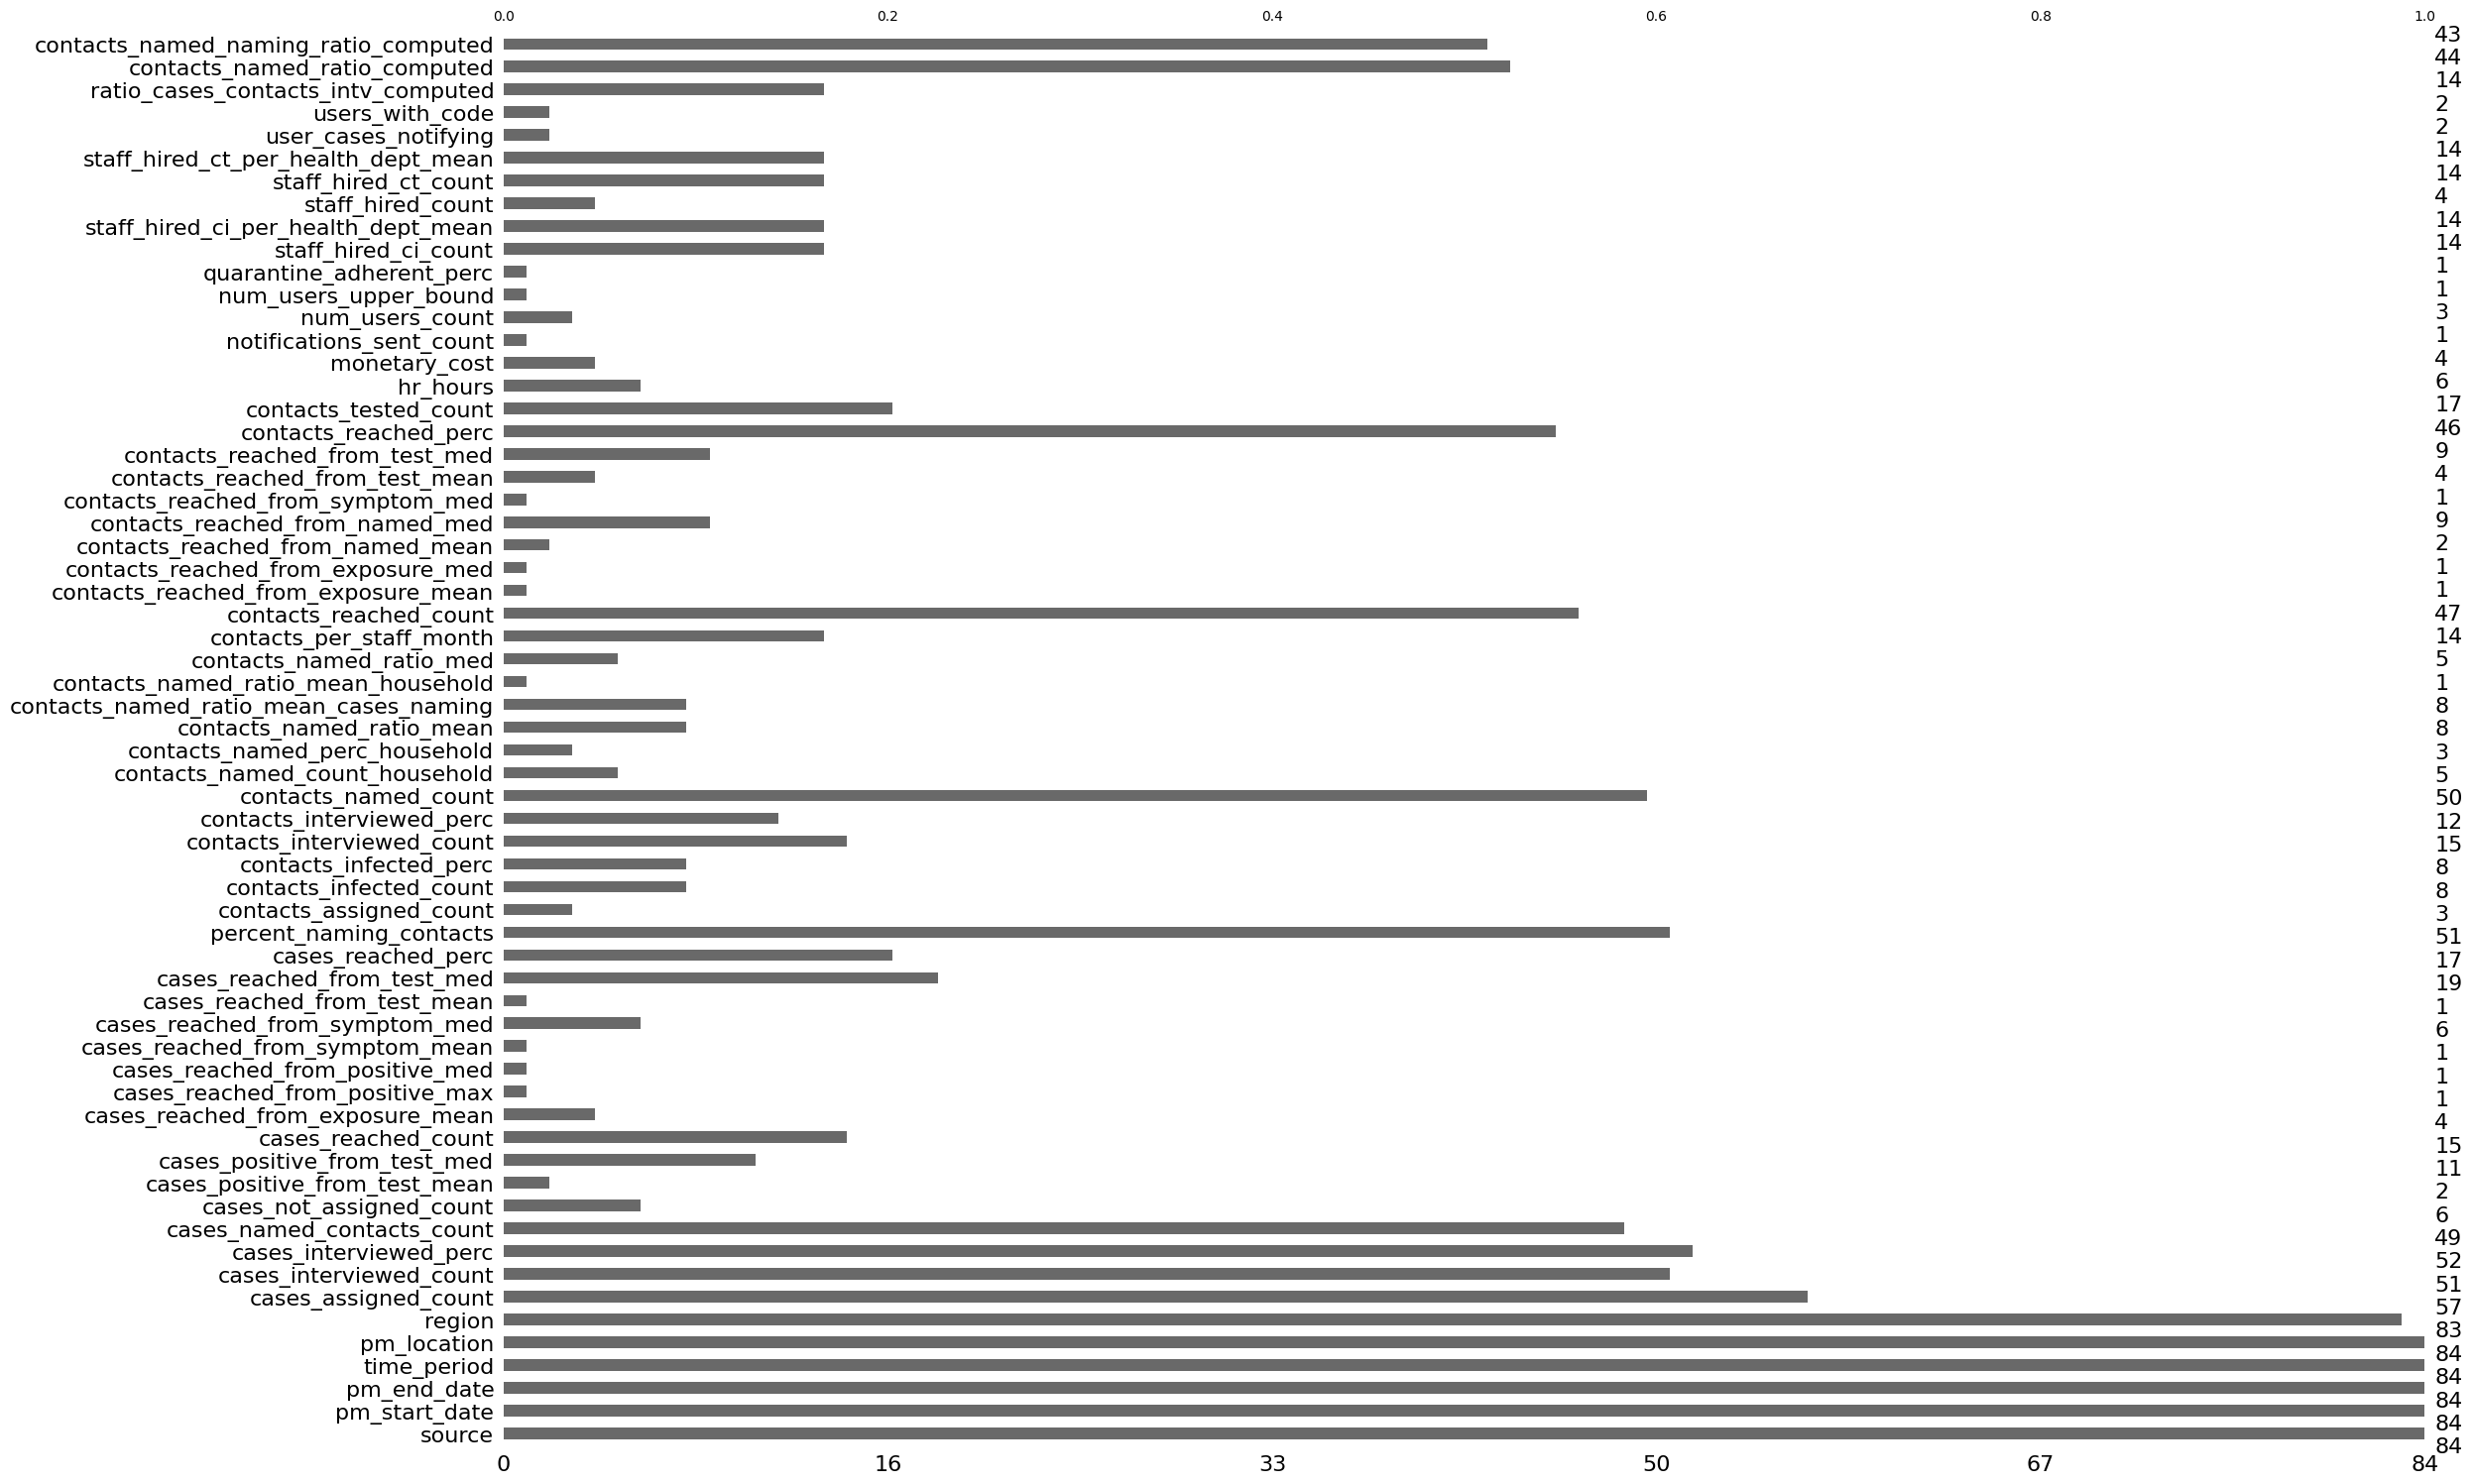

In [299]:
# missingness map
#msno.matrix(df[cols_interest], labels=True, label_rotation=90)
#plt.show()
display(Markdown('#### Map of Available Article Data from cols_interest'))
msno.bar(df[cols_interest])

### Data Analysis

#### Random Exploration

In [300]:
# data options: df, df_non_stargel, df_stargel

In [301]:
assn = alt.Chart(df_non_stargel).mark_point().encode(
    alt.X("cases_assigned_count:Q",  scale=alt.Scale(type='log')),
    alt.Y("source:N")
)
int = alt.Chart(df_non_stargel).mark_point().encode(
    alt.X("cases_interviewed_count:Q",  scale=alt.Scale(type='log')),
    alt.Y("source:N")
)
alt.hconcat(assn, int).properties(spacing=5)

alt.HConcatChart(...)

In [334]:
# df['ratio_cases_contacts_intv_computed'] = df['cases_interviewed_count']/df['contacts_interviewed_count']
case = alt.Chart(df_non_stargel).mark_point().encode(
    alt.X("cases_interviewed_perc:Q"),
    alt.Y("source:N")
)
cont = alt.Chart(df_non_stargel).mark_point().encode(
    alt.X("contacts_interviewed_perc:Q"),
    alt.Y("source:N")
)
ratio = alt.Chart(df_non_stargel).mark_point().encode(
    alt.X("ratio_cases_contacts_intv_computed:Q"),
    alt.Y("source:N")
)
alt.hconcat(case, cont, ratio).properties(spacing=5)

alt.HConcatChart(...)

In [335]:
selection = alt.selection_point(fields=['region'], bind='legend')
df_here = df_non_stargel[~df_non_stargel['region'].isin(['Alaska', 'US'])]
df_here.dropna(subset=['region'], inplace=True)

alt.Chart(df_here).mark_point().encode(
    alt.X("time_period:O"),
    alt.Y("cases_interviewed_perc:Q"),
    alt.Size("cases_assigned_count:Q", scale=alt.Scale(type='sqrt')),
    alt.Color("region:N", 
              sort=['South', 'Northeast', 'Midwest', 'Northwest', 'Alaska', 'West', 'US']),
    tooltip = [
        alt.Tooltip("source:N"),
        alt.Tooltip("region:N"),
        alt.Tooltip("cases_assigned_count:Q"),
        alt.Tooltip("pm_start_date:T"),
        alt.Tooltip("pm_end_date:T")
   ]
).properties(
    width=500
).transform_filter(
    selection 
).add_params(
    selection
).interactive()

/Users/kaitlinsinger/.pyenv/versions/3.10.0/envs/venv-inspace/lib/python3.10/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


alt.Chart(...)

### Plots from Doc
At a national level, plot each of the following on a monthly basis. Reporting a table with counts over a given period could also be useful: 

- The number of tests produced.  We want to get this number from “The SARS-CoV-2 test scale-up in the USA”.  Currently I can’t find these numbers in the github repository, but I am hoping these numbers can be found somewhere in their analysis scripts 
- The number of cases reported to the CDC.  This is inside of the weekly_metrics_by_state.csv.  Data should be aggregated for the national level estimates. 
- The number of cases reported in the stargel paper. 
- The number of cases interviewed (also stargel) 
- The number cases interviewed 
- The number of cases reporting contacts 
- The number of contacts reached. 

In [304]:
# number of tests produced

In [400]:
grouped_test_counts_result

,date,overall_outcome,new_results_reported
0,2020/03/01,Inconclusive,1
1,2020/03/01,Negative,286
2,2020/03/01,Positive,63
3,2020/03/02,Inconclusive,3
4,2020/03/02,Negative,416
...,...,...,...
4651,2024/05/29,Negative,619
4652,2024/05/29,Positive,36
4653,2024/06/01,Inconclusive,0
4654,2024/06/01,Negative,2


In [415]:
grouped_test_counts = testing_data.groupby(by=["date"])["new_results_reported"].sum().reset_index()
grouped_test_counts_result = testing_data.groupby(by=["date","overall_outcome"])["new_results_reported"].sum().reset_index()


alt.Chart(grouped_test_counts).mark_bar().encode(
    x=alt.X('yearmonth(date):T', 
            title='Sum of tests administered by start month (CDC weekly data file)',
            scale=alt.Scale(domain=['01/01/2020', '05/31/2024'])
           ),
    y=alt.Y('sum(new_results_reported):Q')
).properties(
    width=650,
    height=50,
    title=""
)

alt.Chart(...)

In [419]:
alt.Chart(grouped_test_counts_result).mark_bar().encode(
    alt.X('yearmonth(date):T', title='Sum of tests administered by start month by outcome (CDC weekly data file)',
            scale=alt.Scale(domain=['01/01/2020', '05/31/2024'])
           ),
    alt.Y('sum(new_results_reported):Q'),
    alt.Color('overall_outcome:N'),
    xOffset='overall_outcome:N'
).properties(
    width=650,
    height=50,
    title=""
)


alt.Chart(...)

In [418]:
# The number of cases reported to the CDC. This is inside of the weekly_metrics_by_state.csv. 
# Data should be aggregated for the national level estimates.
# look into this number
grouped_case_counts = case_counts.groupby(by="start_date").sum().reset_index()

alt.Chart(grouped_case_counts).mark_bar().encode(
    x=alt.X('yearmonth(start_date):T', title='Sum of new cases by start month (CDC weekl data file)'),
    y=alt.Y('sum(new_cases):Q')
).properties(
    width=650,
    height=50,
    title="COVID rates reported to the CDC generally follow the WHO's dataset"
).interactive()

alt.Chart(...)

In [362]:
# The number of cases reported in the stargel paper.
# The number of cases interviewed (also stargel)
long_df = df_stargel.melt(
    id_vars=['pm_start_date'],
    value_vars=['cases_assigned_count', 'cases_interviewed_count','cases_named_contacts_count'],
    var_name='case_type',
    value_name='count'
)
cases = alt.Chart(long_df).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Sum cases by start month (stargel paper)'),
    alt.Y('sum(count):Q', title=None),
    alt.Color('case_type:N'),
    xOffset='case_type:N'
).properties(
    width=550,
    height=200
)

long_df1 = df_stargel.melt(
    id_vars=['pm_start_date'],
    value_vars=['contacts_named_count', 'contacts_reached_count'],
    var_name='case_type',
    value_name='count'
)
# The number of contacts reported in the stargel paper.
# The number of contacts reached (also stargel)


contacts = alt.Chart(long_df1).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Sum contacts by start month (stargel paper)'),
    alt.Y('sum(count):Q', title=None, scale=alt.Scale(domain=[0,6000000])),
    alt.Color('case_type:N'),
    xOffset='case_type:N'
).properties(
    width=550,
    height=200
)
alt.vconcat(cases, contacts).properties(spacing=5)

alt.VConcatChart(...)

In [361]:
# The number of cases reported in the stargel paper.
# The number of cases interviewed (also stargel)
selection = alt.selection_point(fields=['case_type'], bind='legend')

long_df = df_stargel.melt(
    id_vars=['pm_start_date'],
    value_vars=['cases_assigned_count', 'cases_interviewed_count','cases_named_contacts_count','contacts_named_count', 'contacts_reached_count'],
    var_name='case_type',
    value_name='count'
)
comb = alt.Chart(long_df).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Sum counts by start month (stargel paper)'),
    alt.Y('sum(count):Q', title=None),
    alt.Color('case_type:N'),
    #xOffset='case_type:N'
).properties(
    width=550,
    height=200
).transform_filter(
    selection 
).add_params(
    selection
)

comb

alt.Chart(...)

In [352]:
long_df = df_stargel.melt(
    id_vars=['pm_start_date'],
    value_vars=['cases_interviewed_perc', 'percent_naming_contacts','contacts_reached_perc'],
    var_name='case_type',
    value_name='perc'
)
st = alt.Chart(long_df).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Perc by start month 2020-2021 (stargel paper)', scale=alt.Scale(domain=['01/01/2020', '12/31/2021'])),
    alt.Y('perc:Q', title=None, scale=alt.Scale(domain=[0,100])),
    alt.Color('case_type:N'),
    xOffset='case_type:N'
).properties(
    width=650,
    height=200
)

long_df1 = df_non_stargel.melt(
    id_vars=['pm_start_date'],
    value_vars=['cases_interviewed_perc', 'percent_naming_contacts','contacts_reached_perc'],
    var_name='case_type',
    value_name='perc'
)
non_st = alt.Chart(long_df1).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Avg perc by start month 2020-2021 (non-stargel papers)', scale=alt.Scale(domain=['01/01/2020', '12/31/2021'])),
    alt.Y('average(perc):Q', title=None),
    alt.Color('case_type:N'),
    xOffset='case_type:N'
).properties(
    width=650,
    height=200
)
alt.vconcat(st, non_st).properties(spacing=5)

alt.VConcatChart(...)

In [369]:
# stargel paper 
# The number cases interviewed
# The number of cases reporting contacts
# The number of contacts reached.
# Look at this by article contribution
long_df = df_stargel.melt(
    id_vars=['pm_start_date'],
    value_vars=['cases_interviewed_count', 'cases_named_contacts_count','contacts_reached_count'],
    var_name='case_type',
    value_name='count'
)
c1 = alt.Chart(long_df).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Sum cases by start month 2020-2021, linear scale (stargel papers)', scale=alt.Scale(domain=['01/01/2020', '12/31/2021'])),
    alt.Y('sum(count):Q', title=None),
    alt.Color('case_type:N'),
    xOffset='case_type:N'
).properties(
    width=650,
    height=200
)

# non-stargel paper - this is not really useful
# The number cases interviewed
# The number of cases reporting contacts
# The number of contacts reached.
# Look at this by article contribution
long_df = df_non_stargel.melt(
    id_vars=['pm_start_date'],
    value_vars=['cases_interviewed_count', 'cases_named_contacts_count','contacts_reached_count'],
    var_name='case_type',
    value_name='count'
)
c2 = alt.Chart(long_df).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Sum cases by start month 2020-2021, linear scale (non-stargel papers)', scale=alt.Scale(domain=['01/01/2020', '12/31/2021'])),
    alt.Y('sum(count):Q', title=None),
    alt.Color('case_type:N'),
    xOffset='case_type:N'
).properties(
    width=650,
    height=200
)

c3 = alt.Chart(long_df).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Sum cases by start month 2020-2021, log scale (non-stargel papers)', scale=alt.Scale(domain=['01/01/2020', '12/31/2021'])),
    alt.Y('sum(count):Q', title=None, scale=alt.Scale(type='log')),
    alt.Color('case_type:N'),
    xOffset='case_type:N'
).properties(
    width=650,
    height=200
)

alt.vconcat(c1, c2, c3).properties(spacing=5)

alt.VConcatChart(...)

At the national level, it would be interesting to plot the number of reported case investigators and contact tracers across months.  Based on the under-reporting of stargel (compared to the CDC case reported) we can scale up the number of CI/CT staff for an estimate of the national level staffing.  So we would multiply the number of CI/CT staff from stargel by (# of cases reported by CDC / # of cases reported by stargel) for the given month.   

- I would be interested in this estimate plotted against time next to the number of cases reported.
- In a separate figure it would also be interesting to look at the ratio of cases reported vs case investigators.  We could do (imputed national CI staff per national level case) and (Stargel reported CI / Stargel reported cases assigned. 

In [381]:
long_df = df_stargel.melt(
    id_vars=['pm_start_date'],
    value_vars=['cases_assigned_count', 'contacts_named_count'],
    var_name='case_type',
    value_name='count'
)
c1 = alt.Chart(long_df).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Sum cases and staff by start month 2020-2021, linear scale (stargel papers)'),
    alt.Y('sum(count):Q', title=None),
    alt.Color('case_type:N'),
    #xOffset='case_type:N'
).properties(
    width=650,
    height=200
)
c2 = alt.Chart(df_stargel).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Sum cases and staff by start month 2020-2021, linear scale (stargel papers)'),
    alt.Y('staff_hired_ct_count:Q', title=None)
).properties(
    width=650,
    height=200
)
alt.vconcat(c1, c2).properties(spacing=5)

alt.VConcatChart(...)

At the state level, it would be interesting to see what the NPR data found.  We could compare the number of investigators reported by the states (total) to the national estimates described above (both reported by stargel and the imputed estimate).  Because some states don’t report to the NPR data, for comparisons, we would want to scale up these numbers which we could do based on state populations. 
Also, plotting items at the state level, we could plot the # of staff against the state population with different colors for each of the three different months.  We could also plot the number of staff against the number of cases reported by the state. 


In [439]:
df_npr.head()

,Unnamed: 0,Unnamed: 0.1,source,pm_start_date,pm_end_date,pm_location,cases_assigned_count,cases_interviewed_count,cases_interviewed_perc,cases_named_contacts_count,...,staff_hired_count,staff_hired_ct_count,staff_hired_ct_per_health_dept_mean,user_cases_notifying,users_with_code,region,time_period,ratio_cases_contacts_intv_computed,contacts_named_ratio_computed,contacts_named_naming_ratio_computed
72,72,72,NPR,2021-12-01,1/1/22,Alabama,NaN,NaN,NaN,NaN,...,NaN,400.0,NaN,NaN,NaN,NaN,T6,NaN,NaN,NaN
73,73,73,NPR,2021-12-01,1/1/22,Alaska,NaN,NaN,NaN,NaN,...,NaN,345.0,NaN,NaN,NaN,Alaska,T6,NaN,NaN,NaN
74,74,74,NPR,2021-12-01,1/1/22,American Samoa,NaN,NaN,NaN,NaN,...,NaN,9.0,NaN,NaN,NaN,NaN,T6,NaN,NaN,NaN
75,75,75,NPR,2021-12-01,1/1/22,Arizona,NaN,NaN,NaN,NaN,...,NaN,396.0,NaN,NaN,NaN,NaN,T6,NaN,NaN,NaN
76,76,76,NPR,2021-12-01,1/1/22,Arkansas,NaN,NaN,NaN,NaN,...,NaN,840.0,NaN,NaN,NaN,NaN,T6,NaN,NaN,NaN


In [451]:
alt.Chart(df_npr).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Sum of staff hired by start month 2020-2021, (NPR data)'),
    alt.Y('sum(staff_hired_ct_count):Q', title=None)
).properties(
    width=650,
    height=200
)

alt.Chart(...)

In [ ]:
alt.Chart(df_npr).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Sum of staff hired by start month 2020-2021, (NPR data)'),
    alt.Y('sum(staff_hired_ct_count):Q', title=None)
).properties(
    width=650,
    height=200
)

- Contacts elicited per case across all studies… 
    - Both among all cases and among cases reporting contacts 
- What percent of cases are reached across locations / times / sources 
- What percent of contacts are reached across locations / times / sources 
- Proportion of reported contacts that are known.\ 
- Percent of cases that report any number of contacts 
- Include KC results. 

In [328]:
# display(df[['contacts_named_count','cases_interviewed_count','contacts_named_ratio_computed','contacts_named_ratio_mean','contacts_named_ratio_med']].head())
cont = alt.Chart(df_non_stargel).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Average contacts named/per person by month computed'),
    alt.Y('average(contacts_named_ratio_computed):Q', title=None),
).properties(
    width=650,
    height=50
)

# display(df[['contacts_named_count','cases_interviewed_count','contacts_named_ratio_computed','contacts_named_ratio_mean','contacts_named_ratio_med']].head())
cont1 = alt.Chart(df_non_stargel).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Average contacts named/per person naming by month computed'),
    alt.Y('average(contacts_named_naming_ratio_computed):Q', title=None),
).properties(
    width=650,
    height=50
)
cont2 = alt.Chart(df_non_stargel).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Average mean contacts named/per person by month reported'),
    alt.Y('average(contacts_named_ratio_mean):Q', title=None),
).properties(
    width=650,
    height=50
)
alt.vconcat(cont, cont1, cont2).properties(spacing=5)

alt.VConcatChart(...)

In [333]:
# display(df[['contacts_named_count','cases_interviewed_count','contacts_named_ratio_computed','contacts_named_ratio_mean','contacts_named_ratio_med']].head())
cont = alt.Chart(df_stargel).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Average contacts named/per person by month reported'),
    alt.Y('average(hd_contacts_named_ratio_mean_hdcount):Q', title=None),
).properties(
    width=650,
    height=50
)

# display(df[['contacts_named_count','cases_interviewed_count','contacts_named_ratio_computed','contacts_named_ratio_mean','contacts_named_ratio_med']].head())
cont1 = alt.Chart(df_stargel).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Average contacts named/per person naming by month computed'),
    alt.Y('average(contacts_named_naming_ratio_computed):Q', title=None),
).properties(
    width=650,
    height=50
)
cont2 = alt.Chart(df_stargel).mark_bar().encode(
    alt.X('yearmonth(pm_start_date):T', title='Average mean contacts named/per person naming by month reported'),
    alt.Y('average(hd_contacts_named_ratio_mean_cases_naming_mean):Q', title=None),
).properties(
    width=650,
    height=50
)
alt.vconcat(cont, cont1, cont2).properties(spacing=5)

alt.VConcatChart(...)

In [189]:
brush = alt.selection_interval(
    encodings=['x'] # limit selection to x-axis (year) values
)

# dynamic query histogram
years = alt.Chart(df).mark_bar().add_params(
    brush
).encode(
    x=alt.X('yearmonth(pm_start_date):T', title='Sum cases assigned by start month'),
    y=alt.Y('sum(cases_reached_count):Q', title=None)
).properties(
    width=650,
    height=50
)
chart = alt.Chart(df).mark_point().encode(
    alt.X("region:N"),
    alt.Y("cases_reached_perc:Q", scale=alt.Scale(domain=[0,100])),
    alt.Size("cases_assigned_count:Q", ),
    #alt.Color("region:N"),
    tooltip = [
        alt.Tooltip("source:N"),
        alt.Tooltip("pm_start_date:T"),
        alt.Tooltip("pm_end_date:T")
   ],
   opacity=alt.condition(brush, alt.value(0.75), alt.value(0.05))
).properties(
    width=500
)
# chart2 = alt.Chart(df).mark_point().encode(
#     alt.X("cases_reached_perc:Q"),
#     alt.Y("source:N")
# )

alt.vconcat(years, chart).properties(spacing=5)

alt.VConcatChart(...)

In [188]:
brush = alt.selection_interval(
    encodings=['x'] # limit selection to x-axis (year) values
)

# dynamic query histogram
years = alt.Chart(df).mark_bar().add_params(
    brush
).encode(
    x=alt.X('yearmonth(pm_start_date):T', title='Sum cases assigned by start month'),
    y=alt.Y('sum(contacts_reached_count):Q', title=None)
).properties(
    width=650,
    height=50
)
chart = alt.Chart(df).mark_point().encode(
    alt.X("region:N"),
    alt.Y("contacts_reached_perc:Q"),
    alt.Size("contacts_named_count:Q", ),
    #alt.Color("region:N"),
    tooltip = [
        alt.Tooltip("source:N"),
        alt.Tooltip("pm_start_date:T"),
        alt.Tooltip("pm_end_date:T")
   ],
   opacity=alt.condition(brush, alt.value(0.75), alt.value(0.05))
).properties(
    width=500
)
# chart2 = alt.Chart(df).mark_point().encode(
#     alt.X("contacts_reached_perc:Q"),
#     alt.Y("source:N")
# )

alt.vconcat(years, chart).properties(spacing=5)

alt.VConcatChart(...)